# BDA2 - Spark SQL

Redo the exercises BDA1 using Spark SQL whenever possible. There are two ways to write queries in SparkSQL - using built-in API functions or running SQL-like
queries. To pass this lab, you need to use built-in API functions for all the questions, in addition, SQL-like queries for the second question. The slides of this link (https://www.ida.liu.se/~732A54/lab/SparkSQLQuickIntro.pdf) show some examples of Spark SQL.

## Setup

The following code is used to prepare the data files, execute only once and **be careful!**

In [1]:
import pyspark
import pyspark.sql
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import col
import csv
import math
import sys
import pandas as pd

tr_path = "../data/temperature-readings.csv"
tr_big_path = "../data/temperature-readings-big.csv"
pr_path = "../data/precipitation-readings.csv"
sro_path = "../data/stations-Ostergotland.csv"
sr_path = "../data/stations.csv"

In [2]:
sc = pyspark.SparkContext(appName = "Temperature")
sc_sql = pyspark.SQLContext(sc)

temperature_readings = sc.textFile(tr_path)
temperature_readings_big = sc.textFile(tr_big_path)
precipitation_readings = sc.textFile(pr_path)
station_oster_readings = sc.textFile(sro_path)
station_readings = sc.textFile(sr_path)

## Assignment 1

What are the lowest and highest temperatures measured each year for the period 1950- 2014. Provide the lists sorted in the descending order with respect to the maximum temperature. In this exercise you will use the `temperature-readings.csv` file.

In [11]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda p: Row(year=int(p[1].split("-")[0]), temp=float(p[3])))
res = sc_sql.createDataFrame(res)
res = res.filter((res['year'] >= 1950) & (res['year'] <= 2014)).groupBy('year')
res = res.agg(F.max('temp').alias('temp_max'), F.min('temp').alias('temp_min'))

global df

df = res.orderBy('temp_max', ascending=False).toPandas()

CPU times: user 52.1 ms, sys: 12.1 ms, total: 64.2 ms
Wall time: 29.5 s


In [12]:
df.head(10)

,year,temp_max,temp_min
0,1975,35.5,-35.4
1,1994,34.7,-36.6
2,2014,33.7,-34.6
3,1970,33.2,-39.5
4,1989,33.2,-37.2
5,1982,33.0,-42.2
6,1988,32.6,-31.5
7,1986,32.2,-38.4
8,2008,32.2,-32.7
9,2003,32.1,-37.2


**Task 1a:** What are the lowest and highest temperature measured each year for the period 1950 to 2014? Provide the list sorted in the descending order with respect to the maximum temperature. Extend the program to include the station number (not the station name) where the maximum/minimum temperature was measured.

In [16]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda p: Row(station=int(p[0]), year=int(p[1].split("-")[0]), temp=float(p[3])))
res = sc_sql.createDataFrame(res)
res = res.filter((res['year'] >= 1950) & (res['year'] <= 2014))

w = Window.partitionBy('year')

res_max = res.withColumn('temp_max', F.max('temp').over(w)).where(F.col('temp') == F.col('temp_max')).drop('temp')
res_min = res.withColumn('temp_min', F.min('temp').over(w)).where(F.col('temp') == F.col('temp_min')).drop('temp')

global df

df = res_max.join(res_min, "year").orderBy(['temp_max', 'year'], ascending=False).toPandas()

CPU times: user 83 ms, sys: 20 ms, total: 103 ms
Wall time: 3min 46s


In [22]:
df.head(10)

,year,station,temp_max,station,temp_min
0,1975,106100,35.5,122330,-35.4
1,1994,117160,34.7,113410,-36.6
2,2014,106160,33.7,124030,-34.6
3,1989,107400,33.2,114510,-37.2
4,1970,103080,33.2,114510,-39.5
5,1982,102540,33.0,113410,-42.2
6,1988,102540,32.6,114510,-31.5
7,2008,102390,32.2,112530,-32.7
8,1986,115230,32.2,112170,-38.4
9,2005,107140,32.1,112530,-39.1


## Assignment 2

Count the number of readings for each month in the period of 1950-2014 which are higher than 10 degrees. Repeat the exercise, this time taking only distinct readings from each station. That is, if a station reported a reading above 10 degrees in some month, then it appears only once in the count for that month. In this exercise you will use the `temperature-readings.csv` file.

The output should contain the following information:

Year, month, count

In [12]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda p: Row(station=int(p[0]), year=int(p[1].split("-")[0]), month=int(p[1].split("-")[1]), day=int(p[1].split("-")[2]), temp=float(p[3])))
res = sc_sql.createDataFrame(res)
res = res.filter((res['year'] >= 1950) & (res['year'] <= 2014))
res = res.filter(res['temp'] > 10.0)

res = res.groupBy('year', 'month').count().select('year', 'month', F.col('count')).orderBy(['year', 'month'], ascending=False)

global df
df = res.toPandas()

CPU times: user 76.9 ms, sys: 10.9 ms, total: 87.8 ms
Wall time: 36.6 s


In [13]:
df.head(10)

,year,month,count
0,2014,11,440
1,2014,10,4232
2,2014,9,11981
3,2014,8,18535
4,2014,7,24106
5,2014,6,14218
6,2014,5,8455
7,2014,4,2860
8,2014,3,592
9,2013,11,73


The following configuration is used for both SQL statement.

In [14]:
db_temp = temperature_readings.map(lambda l: l.split(";")) \
            .filter(lambda m: (int(m[1][:4]) >= 1950 and int(m[1][:4]) <= 2014)) \
            .map(lambda m: Row(station = m[0], date = m[1], year = m[1].split("-")[0], month = m[1].split("-")[1],
                               time = m[2], temp = float(m[3]), quality = m[4]))

schema = sc_sql.createDataFrame(db_temp)

schema.registerTempTable("temp_schema")

In [15]:
%%time

global res

res = sc_sql.sql("""
    SELECT year, month, COUNT(year) AS count
    FROM temp_schema
    WHERE year >= 1950 AND year <= 2014 and temp > 10
    GROUP BY year, month
    ORDER BY cast(year as integer) DESC, cast(month as integer) DESC
""")

res = res.toPandas()

CPU times: user 41.2 ms, sys: 22.1 ms, total: 63.3 ms
Wall time: 42.7 s


In [16]:
res.head(10)

,year,month,count
0,2014,11,440
1,2014,10,4232
2,2014,09,11981
3,2014,08,18535
4,2014,07,24106
5,2014,06,14218
6,2014,05,8455
7,2014,04,2860
8,2014,03,592
9,2013,11,73


Now we repeat the exercise where we take only distinct readings from each station.

In [17]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda p: Row(station=int(p[0]), year=int(p[1].split("-")[0]), month=int(p[1].split("-")[1]), temp=float(p[3])))
res = sc_sql.createDataFrame(res)
res = res.filter((res['year'] >= 1950) & (res['year'] <= 2014) & (res['temp'] > 10.0))

res = res.groupBy('year', 'month', 'station').count().groupBy('year', 'month').count().select('year', 'month', F.col('count')).orderBy(['year', 'month'], ascending=False)

global df
df = res.toPandas()

CPU times: user 83.5 ms, sys: 32.4 ms, total: 116 ms
Wall time: 36 s


In [19]:
df.head(10)

,year,month,count
0,2014,11,27
1,2014,10,49
2,2014,9,50
3,2014,8,50
4,2014,7,50
5,2014,6,50
6,2014,5,49
7,2014,4,47
8,2014,3,31
9,2013,11,19


In [20]:
%%time

global res

res = sc_sql.sql("""
    SELECT year, month, COUNT(year) AS count
    FROM (
        SELECT year, month, COUNT(year) AS count
        FROM temp_schema
        WHERE year >= 1950 AND year <= 2014 and temp > 10
        GROUP BY year, month, station
    )
    GROUP BY year, month
    ORDER BY cast(year as integer) DESC, cast(month as integer) DESC
""")

res = res.toPandas()

CPU times: user 67.7 ms, sys: 26 ms, total: 93.7 ms
Wall time: 43.8 s


In [21]:
res.head(10)

,year,month,count
0,2014,11,27
1,2014,10,49
2,2014,09,50
3,2014,08,50
4,2014,07,50
5,2014,06,50
6,2014,05,49
7,2014,04,47
8,2014,03,31
9,2013,11,19


## Assignment 3

Find the average monthly temperature for each available station in Sweden. Your result should include average temperature for each station for each month in the period of 1960-2014. Bear in mind that not every station has the readings for each month in this timeframe. In this exercise you will use the `temperature-readings.csvfile`.

The output should contain the following information:

Year, month, station number, average monthly temperature

In [61]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda p: Row(station=int(p[0]), year=int(p[1].split("-")[0]), month=int(p[1].split("-")[1]), day=int(p[1].split("-")[2]), temp=float(p[3])))
res = sc_sql.createDataFrame(res)
res = res.filter((res['year'] >= 1960) & (res['year'] <= 2014))
res = res.groupBy('year', 'month', 'day', 'station')
res = res.agg(F.max('temp').alias('temp_max'), F.min('temp').alias('temp_min'))
res = res.withColumn('davg', (res['temp_max'] + res['temp_min'])/2)
res = res.select('year', 'month', 'day', 'station', 'davg')
res = res.groupBy('year', 'month', 'station').agg(F.mean('davg').alias('average-temperature'))

global df
df = res.orderBy(['year', 'month', 'station'], ascending=False).toPandas()

CPU times: user 235 ms, sys: 36.7 ms, total: 272 ms
Wall time: 40 s


In [62]:
df.head(10)

,year,month,station,average-temperature
0,2014,12,127130,-0.314516
1,2014,12,126440,-6.080645
2,2014,12,126290,-6.509677
3,2014,12,125440,-6.962903
4,2014,12,125170,-7.580645
5,2014,12,124300,-4.764516
6,2014,12,124110,-8.284375
7,2014,12,124030,-7.954839
8,2014,12,123460,-7.901613
9,2014,12,123340,-8.793548


## Assignment 4

Provide  a  list  of  stations  with  their  associated  maximum  measured  temperatures  and maximum  measured  daily  precipitation.  Show  only  those  stations  where  the  maximum temperature is between 25 and 30 degrees and maximum daily precipitation is between 100 mm and 200mm. In this exercise you will use the `temperature-readings.csv` and `precipitation-readings.csv` files. 

The output should contain the following information:

Station number, maximum measured temperature, maximum daily precipitation

In [41]:
%%time

res_t = temperature_readings.map(lambda l: l.split(";"))
res_p = precipitation_readings.map(lambda l: l.split(";"))

res_p = res_p.map(lambda p: Row(year=int(p[1].split("-")[0]), month=int(p[1].split("-")[1]), day=int(p[1].split("-")[2]), station=int(p[0]), precipitation=float(p[3])))
res_p = sc_sql.createDataFrame(res_p)

res_p = res_p.groupBy('year', 'month', 'station', 'day')
res_p = res_p.agg(F.max('precipitation').alias('precip_max'))
res_p = res_p.groupBy('year', 'month', 'station')
res_p = res_p.agg(F.max('precip_max').alias('pmax'), F.min('precip_max').alias('pmin'))
res_p = res_p.filter((res_p['pmin'] >= 100.0) & (res_p['pmax'] <= 200.0))
res_p = res_p.groupBy('station')
res_p = res_p.agg(F.max('pmax').alias('max_daily_precipitation'))

res_t = res_t.map(lambda p: Row(station=int(p[0]), temperature=float(p[3])))
res_t = sc_sql.createDataFrame(res_t)

res_t = res_t.groupBy('station')
res_t = res_t.agg(F.max('temperature').alias('max_temperature'))
res_t = res_t.filter((res_t['max_temperature'] > 25.0) & (res_t['max_temperature'] < 30.0))

global df

df = res_t.join(res_p, "station").orderBy('station', ascending=False).toPandas()

CPU times: user 72 ms, sys: 42.1 ms, total: 114 ms
Wall time: 40 s


In [42]:
df.head()

,station,max_temperature,max_daily_precipitation
0,103100,31.3,6.8
1,102190,31.8,77.0
2,102170,29.1,3.2


## Assignment 5

Calculate the average monthly precipitation for the Östergotland region (list of stations is provided in the separate file) for the period 1993-2016. In order to do this, you will first need to calculate  the  total  monthly  precipitation  for  each  station  before calculating the monthly average (by averaging over stations). In this exercise you will use the `precipitation-readings.csv` and `stations-Ostergotland.csv` files.

HINT (not for the SparkSQL lab): Avoid using joins here! `stations-Ostergotland.csv` is small  and if distributed will cause a number of unnecessary shuffles when joined with precipitation RDD. If you distribute `precipitation-readings.csv` then either repartition your stations RDD to 1 partition or make use of the collect to acquire a python list and broadcast function to broadcast the list to all nodes.

The output should contain the following information:

Year, month, average monthly precipitation

In [37]:
%%time

res_p = precipitation_readings.map(lambda l: l.split(";"))
res_s = station_oster_readings.map(lambda l: l.split(";"))

res_s = res_s.map(lambda m: int(m[0])).collect()
res_s = sc.broadcast(value=res_s)

res_p.take(2)
res_p = res_p.map(lambda p: Row(station=int(p[0]), year=int(p[1].split('-')[0]), month=int(p[1].split('-')[1]), day=int(p[1].split('-')[2]), precipitation = float(p[3])))
res_p = sc_sql.createDataFrame(res_p)
res_p = res_p.filter((res_p['year'] >= 1993) & (res_p['year'] <= 2016))

res = res_p.where(res_p['station'].isin(res_s.value))

res = res.groupBy('year', 'month', 'station').agg(F.sum('precipitation').alias('precipitation_cum'))
res = res.groupBy('year', 'month').agg(F.avg('precipitation_cum').alias('precipitation_avg'))

global df

df = res.orderBy(['year', 'month'], ascending=False).toPandas()

In [38]:
df.head(10)

,year,month,precipitation_avg
0,2016,7,0.0000
1,2016,6,47.6625
2,2016,5,29.2500
3,2016,4,26.9000
4,2016,3,19.9625
5,2016,2,21.5625
6,2016,1,22.3250
7,2015,12,28.9250
8,2015,11,63.8875
9,2015,10,2.2625


## Assignment 6

Compare the average monthly temperature (find the difference) in the period 1950-2014 for all stations in Östergotland with long-term monthly averages in the period of 1950-1980. Make a plot of your results. 

HINT: The first step is to find the monthly averages for each station. Then, you can average over all stations to acquire the average temperature for a specific year and month. This RDD/DataFrame can beu sed to compute the long-term average by averaging over all the years in the interval.

The out put should contain the following information:

Year, month, difference

In [20]:
%%time

global res_t
global res_s

res_t = temperature_readings.map(lambda l: l.split(";"))
res_s = station_oster_readings.map(lambda l: l.split(";"))

res_s = res_s.map(lambda m: int(m[0])).collect()
res_s = sc.broadcast(value=res_s)

res_t = res_t.map(lambda p: Row(year=int(p[1].split("-")[0]), month=int(p[1].split("-")[1]), day=int(p[1].split("-")[2]), station=int(p[0]), temp=float(p[3])))
res_t = sc_sql.createDataFrame(res_t)
res_t = res_t.filter((res_t['year'] >= 1950) & (res_t['year'] <= 2014))
res_t = res_t.where(res_t['station'].isin(res_s.value))
res_t = res_t.groupBy('year', 'month', 'day', 'station')
res_t = res_t.agg(F.max('temp').alias('temp_max'), F.min('temp').alias('temp_min'))

res_t = res_t.withColumn('davg', (res_t['temp_max'] + res_t['temp_min'])/2)
res_t = res_t.select('year', 'month', 'day', 'station', 'davg')
res_t = res_t.groupBy('year', 'month', 'station').agg(F.mean('davg').alias('davg'))
res_t = res_t.groupBy('year', 'month').agg(F.mean('davg').alias('davg'))

res_t_bigger_range = res_t.filter((res_t['year'] >= 1950) & (res_t['year'] <= 1980))
res_t_bigger_range = res_t_bigger_range.groupBy('month').agg(F.mean('davg').alias('average-temperature'))

res = res_t_bigger_range.join(res_t, "month")
res = res.withColumn('temperature-difference', res['average-temperature'] - res['davg'])
res = res.select('year', 'month', 'temperature-difference')

global df

df = res.orderBy(['year', 'month']).toPandas()

CPU times: user 214 ms, sys: 61.9 ms, total: 276 ms
Wall time: 6min 52s


In [21]:
df.head(10)

,year,month,temperature-difference
0,1950,1,2.004831
1,1950,2,-2.347990
2,1950,3,-2.492232
3,1950,4,-1.600693
4,1950,5,-0.982352
5,1950,6,0.216232
6,1950,7,1.489154
7,1950,8,-0.241517
8,1950,9,-0.343179
9,1950,10,0.459923


In [11]:
# Difference by Year-Month
df['date'] = df['year'].map(str) + "-" + df['month'].map(str)
df.plot.line(x = 'date', y = 'temperature-difference', figsize=(15,10), title = "Difference by Year-Month");

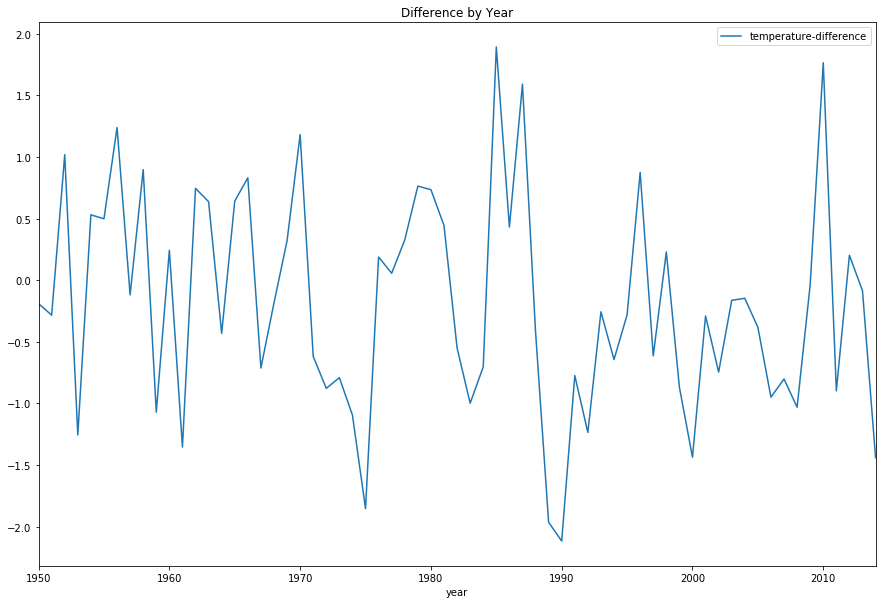

In [12]:
# Difference by Year
df2 = df.groupby(['year'])['temperature-difference'].mean().to_frame()
df2.reset_index(level=0, inplace=True)
df2.plot.line(x = 'year', y = 'temperature-difference', figsize=(15,10), title = "Difference by Year")

**Comment:**  It does not seem like there is a trend across years which makes sense since we don’t expect any temperature changes in the long-term. However, we can observe that there were some years with especially large (e.g. 1990) and especially small temperature differences (e.g. 1985). Hence, the differences may vary noticeably from year to year.

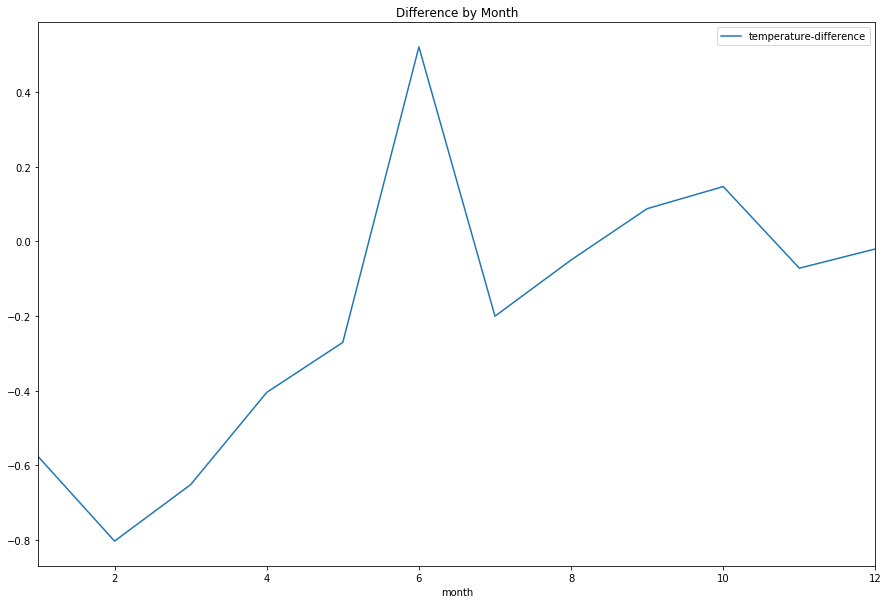

In [13]:
# Difference by Month
df3 = df.groupby(['month'])['temperature-difference'].mean().to_frame()
df3.reset_index(level=0, inplace=True)
df3.plot.line(x = 'month', y = 'temperature-difference', figsize=(15,10), title = "Difference by Month");

**Comment:** We can see that the differences in temperature are much larger in the winter months than in the summer months (see “Difference by Month” plot). This makes sense since we computed the difference as: Difference = Östergotland - General. We expect Östergotland to have warmer temperatures in general than more northern parts of Sweden in the Winter period and Östergotland is in the south. Our expectation is fulfilled since the difference is larger in the winter months.

In [ ]:
sc.stop()